# Interactive Visualizion with Open Altimetry & Google Earth Engine

By Philipp Arndt \
Scripps Institution of Oceanography, University of California San Diego \
Github: [@fliphilipp](https://github.com/fliphilipp) \
Contact: parndt@ucsd.edu

Copied and modified by Ben Purinton, 9 AUG 2023

In [35]:
%matplotlib widget 
import os
import ee
import geemap
import requests
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
from ipywidgets import Layout
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp
import json

    
The import below is a class that I wrote myself. It helps us read and store data from the OpenAltimetry API.  
If you are interested in how this works, you can find the code in `utils/oa.py`.

In [36]:
import sys
sys.path.append('/home/jovyan/surfit/shared_code')
print(sys.path)

from utils.oa import dataCollector

['/home/jovyan/surfit/contributors/ben', '/srv/conda/envs/notebook/share/qgis/python/plugins', '/srv/conda/envs/notebook/share/qgis/python', '/home/jovyan/surfit/contributors/ben', '/srv/conda/envs/notebook/lib/python310.zip', '/srv/conda/envs/notebook/lib/python3.10', '/srv/conda/envs/notebook/lib/python3.10/lib-dynload', '', '/srv/conda/envs/notebook/lib/python3.10/site-packages', '/home/jovyan/surfit/shared_code', '/home/jovyan/surfit/shared_code', '/home/jovyan/surfit/shared_code']


In [37]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## Get data dictionary

In [38]:
# Load JSON data from a file into a Python dictionary
with open('/home/jovyan/surfit/data/icesat2_tracks.json') as json_file:
    data_dict = json.load(json_file)

data_dict

{'utqiagvik': {'granule_id': 'ATL03_20220417011336_03811505_006_02.h5',
  'beam': 'gt1l',
  'viz_url': 'http://openaltimetry.org/data/api/icesat2/atl03?date=2022-04-17&minx=-156.83823035497537&miny=71.24790555527827&maxx=-156.36503098588742&maxy=71.46395004246523&trackId=381&outputFormat=json'},
 'blackrock': {'granule_id': 'ATL03_20200708170622_02040802_006_01.h5',
  'beam': 'gt1l',
  'viz_url': 'http://openaltimetry.org/data/api/icesat2/atl03?date=2020-07-08&minx=-119.31823117419968&miny=40.61614913888411&maxx=-119.17751566966596&maxy=40.85301044291694&trackId=204&beamName=gt1l&outputFormat=json'}}

## General Viz

In [39]:
list_of_sites = list(data_dict.keys())
list_of_sites

['utqiagvik', 'blackrock']

The code above is found more concisely in one more method: 
- `dataCollector.visualize_sentinel2()`

This one has some default parameters, which you can change when running it: 
```
- max_cloud_prob = 20
- days_buffer = 10
- gamma_value = 1.8
- title = 'ICESat-2 data'
- imagery_filename = 'my-satellite-image.tif'
- plot_filename = 'my-plot.jpg'
```

We can now do everything we did in this tutorial in just three lines!

--> Getting data from OpenAltimetry.
---> requesting ATL03 data... 50283 data points.
---> requesting ATL06 data... 1215 data points.
---> requesting ATL07 data... 1171 data points.
---> requesting ATL08 data... 243 data points.
---> requesting ATL10 data... No data.
---> requesting ATL12 data... 7 data points.
---> requesting ATL13 data... 1109 data points.
The ground track is 24.2 km long.
Looking for Sentinel-2 images from 2022-04-07T12:00:00 to 2022-04-27T12:00:00 --> there are 9 cloud-free images.
--> Closest cloud-free Sentinel-2 image to ICESat:
    - product_id: S2A_MSIL2A_20220417T222541_N0400_R015_T04WEE_20220418T013027
    - time difference: Same day as ICESat-2
    - mean along-track cloud probability: 1.0
--> Downloaded the 8-bit RGB image as my-satellite-image.tif.
--> Saved plot as utqiagvik_open_altimetry_sentinel_plot.png.
--> Getting data from OpenAltimetry.
---> requesting ATL03 data... 51426 data points.
---> requesting ATL06 data... No data.
---> requesting ATL07 d

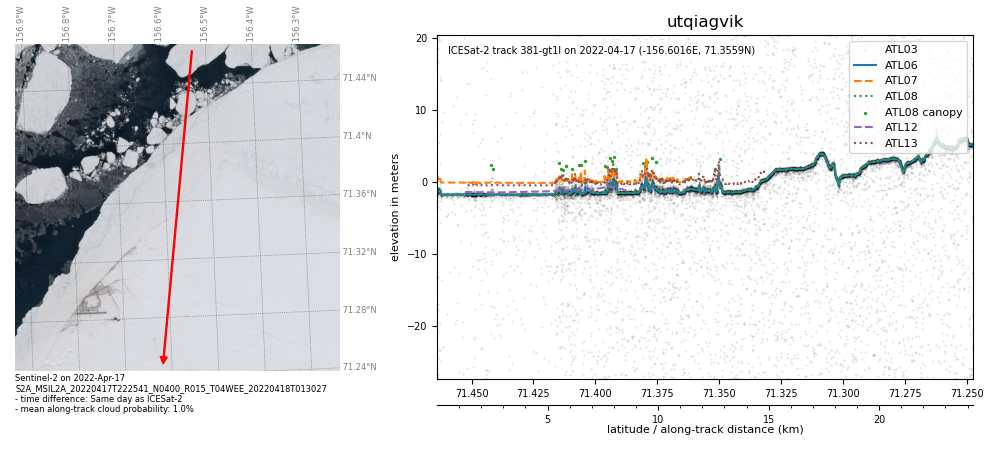

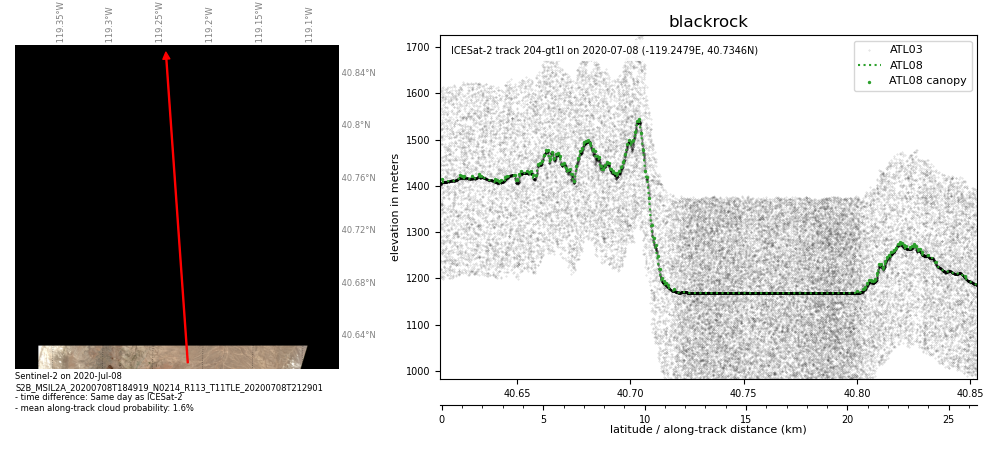

In [40]:
for site in list_of_sites:
    url = data_dict[site]['viz_url']
    beam = data_dict[site]['beam']
    
    is2data = dataCollector(oaurl=url, beam=beam)
    fig = is2data.visualize_sentinel2(max_cloud_prob=5, 
                                      plot_filename=f"{site}_open_altimetry_sentinel_plot.png", 
                                      title=site,
                                      days_buffer=10)

## Below: Additional plotting for interactive maps (need to cleanup!)

### Getting the OpenAltimetry info into python
All we need to do is to paste the API URL that we copied from the webpage into a string. 
We also need to specify which beam we would like to look at. The **GT1R** ground track looks funky, so let's look at that one!

In [7]:
# paste the API URL from OpenAltimetry below, and specify the beam you are interested in
oa_api_url = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2022-04-17&minx=-156.83823035497537&miny=71.24790555527827&maxx=-156.36503098588742&maxy=71.46395004246523&trackId=381&outputFormat=json'
gtx = 'gt2l'

We can now initialize a `dataCollector` object, using the copy-pasted OpenAltimetry API URL, and the beam we would like to look at. \
*(Again, I defined this class in `utils/oa.py` to do some work for us in the background.)*

In [8]:
is2data = dataCollector(oaurl=oa_api_url,beam=gtx, verbose=True)

OpenAltimetry API URL: http://openaltimetry.org/data/api/icesat2/atlXX?date=2022-04-17&minx=-156.83823035497537&miny=71.24790555527827&maxx=-156.36503098588742&maxy=71.46395004246523&trackId=381&outputFormat=json&beamName=gt2l&client=jupyter
Date: 2022-04-17
Track: 381
Beam: gt2l
Latitude limits: [71.24790555527827, 71.46395004246523]
Longitude limits: [-156.83823035497537, -156.36503098588742]


Alternatively, we could use a date, track number, beam, and lat/lon bounding box as input to the `dataCollector`.

In [9]:
# date = '2021-08-22'
# rgt = 909
# beam = 'gt1r'
# latlims = [77.5326, 77.5722]
# lonlims = [-23.9891, -23.9503]
# is2data = dataCollector(date=date, latlims=latlims, lonlims=lonlims, track=rgt, beam=gtx, verbose=True)

Note that this also constructs the API url for us.

### Requesting the data from the OpenAltimetry API
Here we use the `requestData()` function of the `dataCollector` class, which is defined in `utils/oa.py`. It downloads all data products that are available on OpenAltimetry based on the inputs with which we initialized our `dataCollector`, and writes them to pandas dataframes.

In [10]:
is2data.requestData(verbose=True)

---> requesting ATL03 data... 49267 data points.
---> requesting ATL06 data... 1214 data points.
---> requesting ATL07 data... 812 data points.
---> requesting ATL08 data... 243 data points.
---> requesting ATL10 data... No data.
---> requesting ATL12 data... 7 data points.
---> requesting ATL13 data... 742 data points.


The data are now stored as data frames in our `dataCollector` object. To verify this, we can run the cell below.

In [11]:
vars(is2data)

{'url': 'http://openaltimetry.org/data/api/icesat2/atlXX?date=2022-04-17&minx=-156.83823035497537&miny=71.24790555527827&maxx=-156.36503098588742&maxy=71.46395004246523&trackId=381&outputFormat=json&beamName=gt2l&client=jupyter',
 'date': '2022-04-17',
 'track': 381,
 'beam': 'gt2l',
 'latlims': [71.24790555527827, 71.46395004246523],
 'lonlims': [-156.83823035497537, -156.36503098588742],
 'atl03':              lat         lon           h   conf
 0      71.463957 -156.622363 -151.382500  Noise
 1      71.463933 -156.622361  -80.128790  Noise
 2      71.463906 -156.622391 -202.056610  Noise
 3      71.463887 -156.622396 -188.399890  Noise
 4      71.463854 -156.622371   56.177690  Noise
 ...          ...         ...         ...    ...
 49262  71.247934 -156.710772    8.556671   High
 49263  71.247927 -156.710775    8.769092   High
 49264  71.247921 -156.710777    8.780064   High
 49265  71.247915 -156.710780    8.545765   High
 49266  71.247902 -156.710785    8.441950   High
 
 [49267 

## Plotting the ICESat-2 data
Now let's plot this data. Here, we are just creating an empty figure `fig` with axes `ax`.

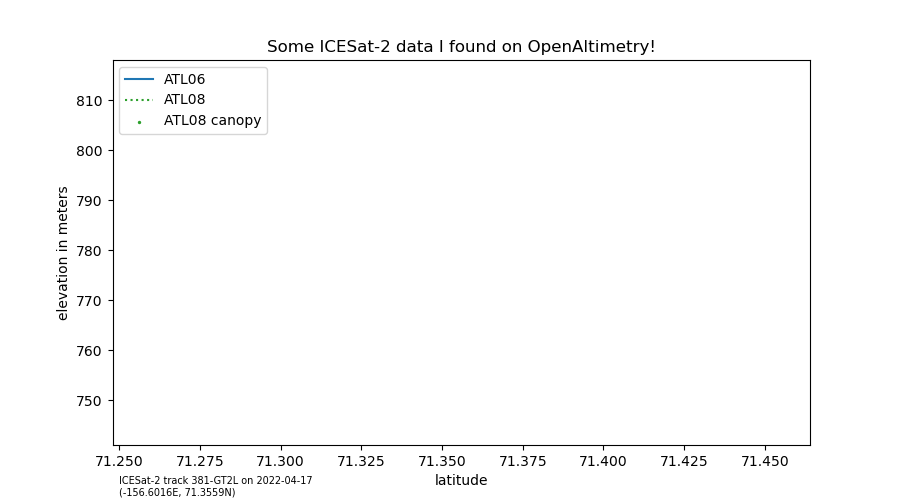

In [12]:
# create the figure and axis
fig, ax = plt.subplots(figsize=[9,5])

# plot the data products
atl06, = ax.plot(is2data.atl06.lat, is2data.atl06.h, c='C0', linestyle='-', label='ATL06')
atl08, = ax.plot(is2data.atl08.lat, is2data.atl08.h, c='C2', linestyle=':', label='ATL08')
if np.sum(~np.isnan(is2data.atl08.canopy))>0:
    atl08canopy = ax.scatter(is2data.atl08.lat, is2data.atl08.h+is2data.atl08.canopy, s=2, c='C2', label='ATL08 canopy')

# add labels, title and legend
ax.set_xlabel('latitude')
ax.set_ylabel('elevation in meters')
ax.set_title('Some ICESat-2 data I found on OpenAltimetry!')
ax.legend(loc='upper left')

# add some text to provide info on what is plotted
info = 'ICESat-2 track {track:d}-{beam:s} on {date:s}\n({lon:.4f}E, {lat:.4f}N)'.format(track=is2data.track, 
                                                                                        beam=is2data.beam.upper(), 
                                                                                        date=is2data.date, 
                                                                                        lon=np.mean(is2data.lonlims), 
                                                                                        lat=np.mean(is2data.latlims))
infotext = ax.text(0.01, -0.08, info,
                   horizontalalignment='left', 
                   verticalalignment='top', 
                   transform=ax.transAxes,
                   fontsize=7,
                   bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))

# set the axis limits
ax.set_xlim((is2data.atl03.lat.min(), is2data.atl03.lat.max()))
ax.set_ylim((741, 818));

Let's add the ATL03 photons to better understand what might be going on here.

In [13]:
atl03 = ax.scatter(is2data.atl03.lat, is2data.atl03.h, s=1, color='black', label='ATL03', zorder=-1)
ax.legend(loc='upper left')
fig.tight_layout()

### Saving the plot to a file

In [14]:
#fig.savefig('my-plot.jpg', dpi=300)

To make plots easier to produce, the `dataCollector` class also has a method to plot the data that we downloaded. 

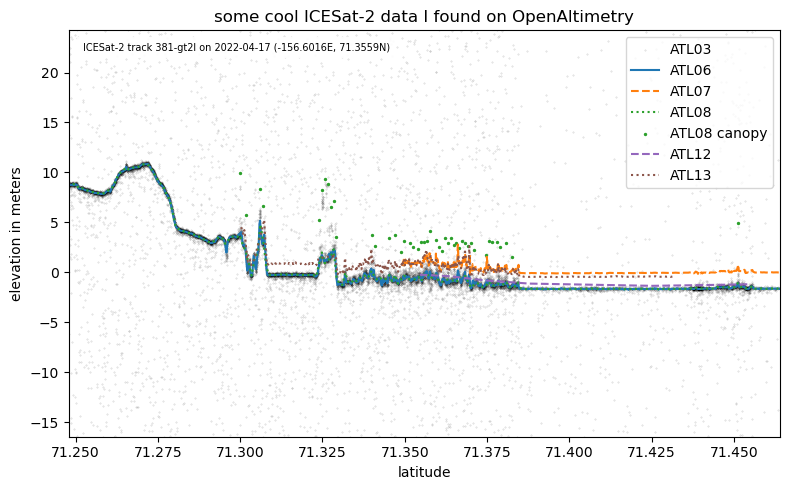

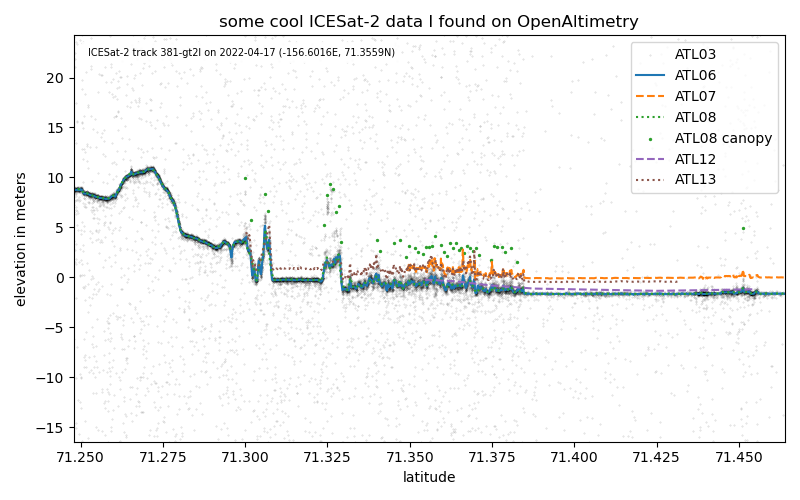

In [15]:
fig = is2data.plotData();
fig

## Ground Track Stats
So far we have only seen the data in elevation vs. latitude space. It's probably good to know what the scale on the x-axis is here in units that we're familiar with. 

In [16]:
def dist_latlon2meters(lat1, lon1, lat2, lon2):
    # returns the distance between two coordinate points - (lon1, lat1) and (lon2, lat2) along the earth's surface in meters.
    R = 6371000
    def deg2rad(deg):
        return deg * (np.pi/180)
    dlat = deg2rad(lat2-lat1)
    dlon = deg2rad(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

lat1, lat2 = is2data.atl08.lat[0], is2data.atl08.lat.iloc[-1]
lon1, lon2 = is2data.atl08.lon[0], is2data.atl08.lon.iloc[-1]

ground_track_length = dist_latlon2meters(lat1, lon1, lat2, lon2)
print('The ground track is about %.1f kilometers long.' % (ground_track_length/1e3))

The ground track is about 24.1 kilometers long.


## Google Earth Engine

Google Earth Engine (GEE) has a large [catalog](https://developers.google.com/earth-engine/datasets) of geospatial raster data, which is ready for analysis in the cloud. It also comes with an online JavaScript code editor.  
<img src="https://raw.githubusercontent.com/fliphilipp/images/main/gee_codeeditor.png" alt="gif showing how to get to the data in OpenAltimetry" width="400px"> 
But since we all seem to be using python, it would be nice to have these capabilities available in our Jupyter comfort zone...

Thankfully, there is a [python API for GEE](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api), which we have imported using `import ee` earlier. It doesn't come with an interactive map, but the python package [geemap](https://geemap.org/) has us covered!

### Show a ground track on a map
We can start working on our map by calling `geemap.Map()`. This just gives us a world map with a standard basemap. 

In [17]:
from ipywidgets import Layout
Map = geemap.Map(layout=Layout(width='70%', max_height='450px'))
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Now we need to add our ICESat-2 gound track to that map. Let's use the lon/lat coordinates of the ATL08 data product for this.  
We also need to specify which **Coordinate Reference System (CRS)** our data is in. The longitude/latitude system that we are all quite familiar with is referenced by [`EPSG:4326`](https://epsg.io/4326). To add the ground track to the map we need to turn it into an [Earth Engine "Feature Collection"](https://developers.google.com/earth-engine/guides/feature_collections).

In [18]:
ground_track_coordinates = list(zip(is2data.atl08.lon, is2data.atl08.lat))
ground_track_projection = 'EPSG:4326' # <-- this specifies that our data longitude/latitude in degrees [https://epsg.io/4326]
gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates, 
                                      proj=ground_track_projection, 
                                      geodesic=True))
gtx_feature

Now that we have it in the right format, we can add it as a **layer** to the map.

In [19]:
Map.addLayer(gtx_feature, {'color': 'red'}, 'ground track')

According to the cell above this should be a red line. But we still can't see it, because we first need to tell the map where to look for it.  
Let's calculate the center longitude and latitude, and center the map on it. 

In [20]:
center_lon = (lon1 + lon2) / 2
center_lat = (lat1 + lat2) / 2
Map.setCenter(center_lon, center_lat, zoom=4);

So we actually couldn't see it because it was in Greenland.  
Unfortunately the basemap here doesn't give us much more information. Let's add a satellite imagery basemap.
This is a good time to look at the layer control on the top right.

In [21]:
Map.add_basemap('SATELLITE') # <-- this adds a layer called 'Google Satellite'
Map.layer_opacity(name='Google Satellite', opacity=0.5)
Map.setCenter(center_lon, center_lat, zoom=7);
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')

...looks like this basemap still doesn't give us any more clues about the nature of this weird ICESat-2 data. Let's dig deeper.

### Query for Sentinel-2 images
Both of these Sentinel-2 satellites take images of most places on our planet at least every week or so. Maybe these images can tell us what was happening here around the same time that ICESat-2 acquired our data?

The imagery scenes live in image collections on Google Earth Engine.  
You can find all collections here: [https://developers.google.com/earth-engine/datasets/catalog/](https://developers.google.com/earth-engine/datasets/catalog/)

The above link tells us we can find some images under `'COPERNICUS/S2_SR_HARMONIZED'`.

In [22]:
collection_name1 = 'COPERNICUS/S2_SR_HARMONIZED'  # Landsat 8 earth engine collection 
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T2

#### Access an image collection
To access the collection, we call `ee.ImageCollection`:

In [23]:
collection = ee.ImageCollection(collection_name1)
collection

Can we find out how many images there are in total?

In [24]:
number_of_scenes = collection.size()
print(number_of_scenes)

ee.Number({
  "functionInvocationValue": {
    "functionName": "Collection.size",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "ImageCollection.load",
          "arguments": {
            "id": {
              "constantValue": "COPERNICUS/S2_SR_HARMONIZED"
            }
          }
        }
      }
    }
  }
})


**Actually, asking for the size of the collection does not do anything!** 🤔

It just tells Earth Engine on the server-side that this variable refers to the size of the collection, which we may need later to do some analysis on the server. As long as this number is not needed, Earth Engine will not go through the trouble actually computing it. 

To force Earth Engine to compute and get any information on the client side (our local machine / Cryocloud), we need to call `.getInfo()`. In this case that would be ```number_of_scenes = collection.size().getInfo()```.

*Because this command would ask Earth Engine to count every single Sentinel-2 file that exists, this command would take a really long time to execute. I will avoid this here and just give you the answer from when I wrote this tutorial.*

In [25]:
# number_of_scenes = collection.size().getInfo()
number_of_scenes = 19323842
print('There are %i number of scenes in the image collection' % number_of_scenes)

There are 19323842 number of scenes in the image collection


#### Filter an image collection by location and time
Who wants to look at almost 20 million pictures? I don't. So let's try to narrow it down.  
Let's start with only images that overlap with the center of our ground track. 

In [26]:
# the point of interest (center of the track) as an Earth Engine Geometry
point_of_interest = ee.Geometry.Point(center_lon, center_lat)

In [27]:
collection = collection.filterBounds(point_of_interest)

In [28]:
print('There are {number:d} images in the spatially filtered collection.'.format(number=collection.size().getInfo()))

There are 897 images in the spatially filtered collection.


Much better! Now let's only look at images that were taken soon before or after ICESat-2 passed over this spot.

In [29]:
days_buffer_imagery = 6

In [30]:
dateformat = '%Y-%m-%d'
datetime_requested = datetime.strptime(is2data.date, dateformat)
search_start = (datetime_requested - timedelta(days=days_buffer_imagery)).strftime(dateformat)
search_end = (datetime_requested + timedelta(days=days_buffer_imagery)).strftime(dateformat)
print('Search for imagery from {start:s} to {end:s}.'.format(start=search_start, end=search_end))

Search for imagery from 2022-04-11 to 2022-04-23.


In [31]:
collection = collection.filterDate(search_start, search_end)
print('There are {number:d} images in the spatially filtered collection.'.format(number=collection.size().getInfo()))

There are 10 images in the spatially filtered collection.


We can also sort the collection by date (`'system:time_start'`), to order the images by acquisition time.

In [32]:
# collection = collection.sort('system:time_start') 

#### Get image collection info
Again, we need to use `.getInfo()` to actually see any information on our end. This is a python dictionary. 

In [33]:
info = collection.getInfo()
type(info)

dict

Let's see what's inside!

In [34]:
info.keys()

dict_keys(['type', 'bands', 'id', 'version', 'properties', 'features'])

`'features'` sounds like it could hold information about the images we are trying to find...

In [35]:
len(info['features'])

10

A list of 34 things! Those are probably the 34 images in the collection. Let's pick the first one and dig deeper!

In [36]:
feature_number = 0
info['features'][0].keys()

dict_keys(['type', 'bands', 'version', 'id', 'properties'])

In [37]:
info['features'][feature_number]['id']

'COPERNICUS/S2_SR_HARMONIZED/20220411T225529_20220411T225528_T04WEE'

Looks like we found a reference to a Sentinel-2 image! Let's look at the `'bands'`.

In [38]:
for band in info['features'][feature_number]['bands']:
    print(band['id'], end=', ')

B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, B12, AOT, WVP, SCL, TCI_R, TCI_G, TCI_B, MSK_CLDPRB, MSK_SNWPRB, QA10, QA20, QA60, 

`'properties'` could be useful too! 

In [39]:
info['features'][0]['properties'].keys()

dict_keys(['SPACECRAFT_NAME', 'SATURATED_DEFECTIVE_PIXEL_PERCENTAGE', 'BOA_ADD_OFFSET_B12', 'CLOUD_SHADOW_PERCENTAGE', 'system:footprint', 'SENSOR_QUALITY', 'GENERATION_TIME', 'CLOUDY_PIXEL_OVER_LAND_PERCENTAGE', 'CLOUD_COVERAGE_ASSESSMENT', 'THIN_CIRRUS_PERCENTAGE', 'GRANULE_MEAN_WV', 'BOA_ADD_OFFSET_B1', 'BOA_ADD_OFFSET_B2', 'DATASTRIP_ID', 'BOA_ADD_OFFSET_B5', 'BOA_ADD_OFFSET_B6', 'BOA_ADD_OFFSET_B3', 'BOA_ADD_OFFSET_B4', 'BOA_ADD_OFFSET_B9', 'BOA_ADD_OFFSET_B7', 'BOA_ADD_OFFSET_B8', 'GRANULE_ID', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8', 'DATATAKE_TYPE', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B9', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B6', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B7', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B4', 'NOT_VEGETATED_PERCENTAGE', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B5', 'RADIOMETRIC_QUALITY', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B2', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B3', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B1', 'HIGH_PROBA_CLOUDS_PERCENTAGE', 'UNCLASSIFIED_PERCENTAGE', 'OZONE_SOURCE', 'GRANULE_MEAN_AOT', 'BOA_ADD_OFFSET_

That's a lot going on right there! But `'GRANULE_ID'` is probably useful. Let's go through all our features and print the product id.

In [40]:
for feature in info['features']:
    print(feature['properties']['GRANULE_ID'])

L2A_T04WEE_A026625_20220411T225528
L2A_T04WEE_A026639_20220412T222529
L2A_T04WEE_A035562_20220413T224534
L2A_T04WEE_A026682_20220415T223528
L2A_T04WEE_A035605_20220416T225536
L2A_T04WEE_A035619_20220417T222537
L2A_T04WEE_A026725_20220418T224526
L2A_T04WEE_A035662_20220420T223536
L2A_T04WEE_A026768_20220421T225527
L2A_T04WEE_A026782_20220422T222527


### Add a Sentinel-2 image to the map
The visible bands in Sentinel-2 are `'B2'`:blue, `'B3'`:green, `'B4'`:red.  
So to show a "true color" RGB composite image on the map, we need to select these bands in the R-G-B order: 

In [41]:
myImage = collection.first()
myImage_RGB = myImage.select('B4', 'B3', 'B2')
vis_params = {'min': 0.0, 'max': 10000, 'opacity': 1.0, 'gamma': 1.5}
Map.addLayer(myImage_RGB, vis_params, name='my image')
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')
Map

Map(bottom=28066.0, center=[71.35593795776367, -156.66655731201172], controls=(WidgetControl(options=['positio…

This seems to have worked. But there's clouds everywhere.

### Calculate the along-track cloud probability
We need a better approach to get anywhere here. To do this, we use not only the [Sentinel-2 Surface Reflectance image collection](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED), but also merge it with the [Sentinel-2 cloud probability collection](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_CLOUD_PROBABILITY), which can be accessed under `COPERNICUS/S2_CLOUD_PROBABILITY`.  

Let's specify a function that adds the cloud probability band to each Sentinel-2 image and calcultes the mean cloud probability in the neighborhood of the ICESat-2 ground track, then map this function over our location/date filtered collection.

In [42]:
def get_sentinel2_cloud_collection(is2data, days_buffer=6, gt_buffer=100):
    
    # create the area of interest for cloud likelihood assessment
    ground_track_coordinates = list(zip(is2data.atl08.lon, is2data.atl08.lat))
    ground_track_projection = 'EPSG:4326' # our data is lon/lat in degrees [https://epsg.io/4326]
    gtx_feature = ee.Geometry.LineString(coords=ground_track_coordinates,
                                     proj=ground_track_projection,
                                     geodesic=True)
    area_of_interest = gtx_feature.buffer(gt_buffer)
    
    datetime_requested = datetime.strptime(is2data.date, '%Y-%m-%d')
    start_date = (datetime_requested - timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%S')
    end_date = (datetime_requested + timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%S')
    print('Search for imagery from {start:s} to {end:s}.'.format(start=start_date, end=end_date))
    
    # Import and filter S2 SR HARMONIZED
    s2_sr_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Import and filter s2cloudless.
    s2_cloudless_collection = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    cloud_collection = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_collection, 'secondary': s2_cloudless_collection,
        'condition': ee.Filter.equals(**{'leftField': 'system:index','rightField': 'system:index'})}))

    cloud_collection = cloud_collection.map(lambda img: img.addBands(ee.Image(img.get('s2cloudless')).select('probability')))
    
    def set_is2_cloudiness(img, aoi=area_of_interest):
        cloudprob = img.select(['probability']).reduceRegion(reducer=ee.Reducer.mean(), 
                                                             geometry=aoi, 
                                                             bestEffort=True, 
                                                             maxPixels=1e6)
        return img.set('ground_track_cloud_prob', cloudprob.get('probability'))
    
    return cloud_collection.map(set_is2_cloudiness)

Get this collection for our ICESat-2 data, and print all the granule IDs and associated cloudiness over the ground track. 

In [43]:
collection = get_sentinel2_cloud_collection(is2data)
info = collection.getInfo()
for feature in info['features']:
    print('%s --> along-track cloud probability: %5.1f %%' % (feature['properties']['GRANULE_ID'],
                                                              feature['properties']['ground_track_cloud_prob']))

Search for imagery from 2022-04-11T00:00:00 to 2022-04-23T00:00:00.
L2A_T04WEE_A026625_20220411T225528 --> along-track cloud probability:  32.5 %
L2A_T04WEE_A026639_20220412T222529 --> along-track cloud probability:   3.8 %
L2A_T04WEE_A035562_20220413T224534 --> along-track cloud probability:   0.4 %
L2A_T04WEE_A026682_20220415T223528 --> along-track cloud probability:   1.0 %
L2A_T04WEE_A035605_20220416T225536 --> along-track cloud probability:   1.0 %
L2A_T04WEE_A035619_20220417T222537 --> along-track cloud probability:   1.0 %
L2A_T04WEE_A026725_20220418T224526 --> along-track cloud probability:   1.2 %
L2A_T04WEE_A035662_20220420T223536 --> along-track cloud probability:   1.7 %
L2A_T04WEE_A026768_20220421T225527 --> along-track cloud probability:   0.3 %
L2A_T04WEE_A026782_20220422T222527 --> along-track cloud probability:   1.2 %


### Filter cloudy images
We specify a certain cloud probability threshold, and then only keep the images that fall below it. Here we are choosing a quite aggressive value of maximum 5% cloud probability...

In [44]:
# filter by maximum allowable cloud probability (in percent)
MAX_CLOUD_PROB_ALONG_TRACK = 0.5
cloudfree_collection = collection.filter(ee.Filter.lt('ground_track_cloud_prob', MAX_CLOUD_PROB_ALONG_TRACK))
print('There are %i cloud-free scenes.' % cloudfree_collection.size().getInfo())

There are 2 cloud-free scenes.


### Sort the collection by time difference from the ICESat-2 overpass
Using the image property `'system:time_start'` we can calculate the time difference from the ICESat-2 overpass and set it as a property. This allows us to sort the collection by it and to make sure that the first image in the collection is the closest-in-time to ICESat-2 image that is also cloud-free. 

In [45]:
# get the time difference between ICESat-2 overpass and Sentinel-2 acquisitions, set as image property
is2time = is2data.date + 'T12:00:00'
def set_time_difference(img, is2time=is2time):
    timediff = ee.Date(is2time).difference(img.get('system:time_start'), 'second').abs()
    return img.set('timediff', timediff)
cloudfree_collection = cloudfree_collection.map(set_time_difference).sort('timediff')

Print some stats for the final collection to make sure everything looks alright.

In [46]:
info = cloudfree_collection.getInfo()
for feature in info['features']:
    s2datetime = datetime.fromtimestamp(feature['properties']['system:time_start']/1e3)
    is2datetime = datetime.strptime(is2time, '%Y-%m-%dT%H:%M:%S')
    timediff = s2datetime - is2datetime
    timediff -= timedelta(microseconds=timediff.microseconds)
    diffsign = 'before' if timediff < timedelta(0) else 'after'
    print('%s --> along-track cloud probability: %5.1f %%, %s %7s ICESat-2' % (feature['properties']['GRANULE_ID'],
              feature['properties']['ground_track_cloud_prob'],np.abs(timediff), diffsign))

L2A_T04WEE_A035562_20220413T224534 --> along-track cloud probability:   0.4 %, 3 days, 13:14:12  before ICESat-2
L2A_T04WEE_A026768_20220421T225527 --> along-track cloud probability:   0.3 %, 4 days, 10:55:39   after ICESat-2


### Show the final image and ground track on the map

In [47]:
first_image_rgb = cloudfree_collection.first().select('B4', 'B3', 'B2')
Map = geemap.Map(layout=Layout(width='70%', max_height='450px'))
Map.add_basemap('SATELLITE')
Map.addLayer(first_image_rgb, vis_params, name='my image')
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')
Map.centerObject(gtx_feature, zoom=12)
Map

Map(center=[71.35593210756403, -156.66653930801877], controls=(WidgetControl(options=['position', 'transparent…

### Download images from Earth Engine

We can use [`.getDownloadUrl()`](https://developers.google.com/earth-engine/apidocs/ee-image-getdownloadurl) on an Earth Engine image.  

It asks for a scale, which is just the pixel size in meters (10 m for Sentinel-2 visible bands). It also asks for the region we would like to export; here we use a [`.buffer`](https://developers.google.com/earth-engine/apidocs/ee-geometry-buffer) around the center.

*(Note: This function can only be effectively used for small download jobs because there is a request size limit. Here, we only download a small region around the ground track, and convert the image to an 8-bit RGB composite to keep file size low. For larger jobs you should use [`Export.image.toDrive`](https://developers.google.com/earth-engine/apidocs/export-image-todrive))*

In [48]:
# create a region around the ground track over which to download data
point_of_interest = ee.Geometry.Point(center_lon, center_lat)
buffer_around_center_meters = ground_track_length*0.52
region_of_interest = point_of_interest.buffer(buffer_around_center_meters)

# make the image 8-bit RGB
s2rgb = first_image_rgb.unitScale(ee.Number(0), ee.Number(10000)).clamp(0.0, 1.0).multiply(255.0).uint8()

# get the download URL
downloadURL = s2rgb.getDownloadUrl({'name': 'mySatelliteImage',
                                          'crs': s2rgb.projection().crs(),
                                          'scale': 10,
                                          'region': region_of_interest,
                                          'filePerBand': False,
                                          'format': 'GEO_TIFF'})
downloadURL

'https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/84e13d667d67afdf218369be41e77976-afda612b831c17fc99539d0149fece0c:getPixels'

We can save the content of the download URL with the [`requests`](https://docs.python-requests.org/en/latest/) library. 

In [49]:
# response = requests.get(downloadURL)
# filename = 'my-satellite-image.tif'
# with open(filename, 'wb') as f:
#     f.write(response.content)
# print('Downloaded %s' % filename)

### Open a GeoTIFF in rasterio
Now that we have saved the file, we can open it locally with the [`rasterio`](https://rasterio.readthedocs.io/en/latest/intro.html) library.

In [ ]:
# myImage = rio.open(filename)
# myImage

### Plot a GeoTIFF in Matplotlib
Now we can easily plot the image in a matplotlib figure, just using the [`rasterio.plot()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html) module. 

In [ ]:
# fig, ax = plt.subplots(figsize=[4,4])
# rioplot.show(myImage, ax=ax);

### transform the ground track into the image CRS
Because our plot is now in the Antarctic Polar Stereographic Coordrinate Reference System, we need to project the coordinates of the ground track from lon/lat values. The [`rasterio.warp.transform`](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html) function has us covered. From then on, it's just plotting in Matplotlib. 

In [ ]:
# gtx_x, gtx_y = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=is2data.atl08.lon, ys=is2data.atl08.lat)
# ax.plot(gtx_x, gtx_y, color='red', linestyle='-')
# ax.axis('off')

## Putting it all together
The code above is found more concisely in one more method: 
- `dataCollector.visualize_sentinel2()`

This one has some default parameters, which you can change when running it: 
```
- max_cloud_prob = 20
- days_buffer = 10
- gamma_value = 1.8
- title = 'ICESat-2 data'
- imagery_filename = 'my-satellite-image.tif'
- plot_filename = 'my-plot.jpg'
```

We can now do everything we did in this tutorial in just three lines!

--> Getting data from OpenAltimetry.
---> requesting ATL03 data... 47578 data points.
---> requesting ATL06 data... 885 data points.
---> requesting ATL07 data... 542 data points.
---> requesting ATL08 data... 136 data points.
---> requesting ATL10 data... No data.
---> requesting ATL12 data... 2 data points.
---> requesting ATL13 data... 234 data points.
The ground track is 17.7 km long.
Looking for Sentinel-2 images from 2022-04-07T12:00:00 to 2022-04-27T12:00:00 --> there are 2 cloud-free images.
--> Closest cloud-free Sentinel-2 image to ICESat:
    - product_id: S2A_MSIL2A_20220413T224531_N0400_R101_T04WEE_20220414T020727
    - time difference: 4 days before ICESat-2
    - mean along-track cloud probability: 0.5
--> Downloaded the 8-bit RGB image as my-satellite-image.tif.
--> Saved plot as utqiagvik_open_altimetry_sentinel_plot.png.


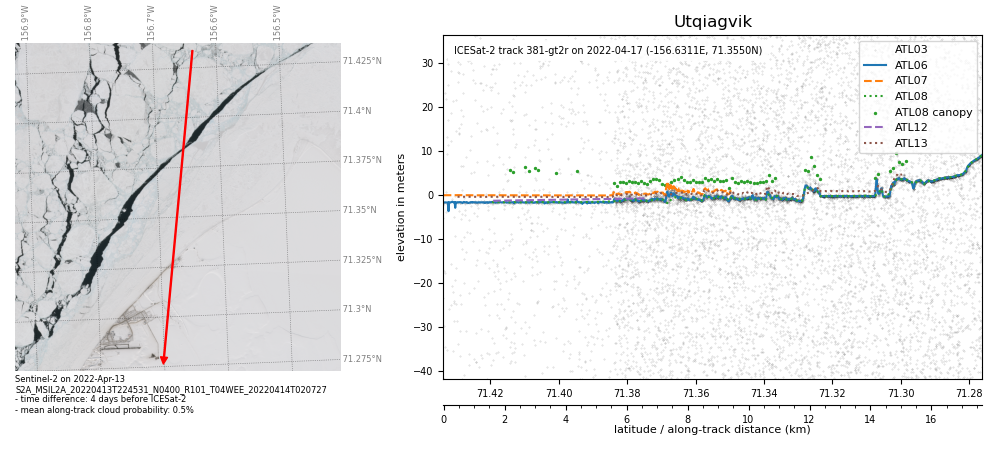

In [51]:
url = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2022-04-17&minx=-156.8188295308167&miny=71.27616032739186&maxx=-156.4433164301686&maxy=71.43377009915022&trackId=381&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
# url = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2022-04-17&minx=-159.02948895987598&miny=70.86003002760418&maxx=-158.98500921722976&maxy=70.94108571348198&trackId=381&beamName=gt1r&beamName=gt1r&outputFormat=json'
is2data = dataCollector(oaurl=url,beam='gt2r')
fig = is2data.visualize_sentinel2(max_cloud_prob=0.5, plot_filename="utqiagvik_open_altimetry_sentinel_plot.png", title='Utqiagvik')

**And now we can also easily run this on some totally different data!**

In [ ]:
url = 'http://openaltimetry.org/data/api/icesat2/atl12?date=2020-12-15&minx=-77.858681&miny=25.728091&maxx=-77.831461&maxy=25.832559&trackId=1254&beamName=gt1r&beamName=gt1l&outputFormat=json'
mydata = dataCollector(oaurl=url, beam='gt1r')
fig = mydata.visualize_sentinel2(max_cloud_prob=20,
                                 title='Nearshore Bathymetry ICESat-2 Data', 
                                 imagery_filename='my-other-satellite-image.tif',
                                 plot_filename='nearshore-bathymetry.jpg')

## Exercise
**Find some data from [OpenAltimetry](https://openaltimetry.org/data/icesat2/), and plot it with a cloud-free satellite image.**

- Look for **small-scale features** - say a few hundred meters to 20 kilometers along-track. (*Hint: OpenAltimetry has a scale bar.*) 
- Bonus points for features where concurrent imagery and the ATL03 photon cloud may give us some information that we would not get from higher-level products alone! 
- *Note:* There is no Sentinel-2 coverage at higher latitudes than ~84°, and there will be no concurrent imagery during polar night.

If you don't know where to start with OpenAltimetry, you can look [here](http://openaltimetry.org/data/icesat2/?annoId=579&shareKey=2f894202007966614f6a751fe892c436).

In [ ]:
##### YOUR CODE GOES HERE - uncomment and edit it! 
# url = 'http://???.org/??'
# gtx = 'gt??'
# is2data = dataCollector(oaurl=url, beam=gtx)
# fig = is2data.visualize_sentinel2(title='<your figure title goes here>', 
#                                   imagery_filename='your-satellite-image.tif',
#                                   plot_filename='your-plot.jpg')

## Summary

 🎉 Congratulations! You've completed this tutorial and have seen how we can put ICESat-2 photon-level data into context using Google Earth Engine and the OpenAltimetry API. 
 
You can explore a few more use cases for this code (and possible solutions for Exercise 2) in [this notebook](./use_examples.ipynb).

## References

To further explore the topics of this tutorial see the following detailed documentation:

* [The OpenAltimetry API](https://openaltimetry.org/data/swagger-ui/)
* [Google Earth Engine JavaScript and Python Guides](https://developers.google.com/earth-engine/guides)
* [Tutorial on Sentinel-2 cloud masking with s2cloudless](https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless)
* [The geemap package](https://geemap.org/) and [tutorials](https://geemap.org/tutorials/)

## Bonus Material: Code for Extracting Along-Track Surface Reflectance Values

Based on javascript code in [this example](https://developers.google.com/earth-engine/tutorials/community/extract-raster-values-for-points).

In [ ]:
# a function for buffering ICESat-2 along-track depth measurement locations by a footprint radius
def bufferPoints(radius, bounds=False):
    def buffer(pt):
        pt = ee.Feature(pt)
        return pt.buffer(radius).bounds() if bounds else pt.buffer(radius)
    return buffer

# a function for extracting Sentinel-2 band data for ICESat-2 along-track depth measurement locations
def zonalStats(ic, fc, reducer=ee.Reducer.mean(), scale=None, crs=None, bands=None, bandsRename=None,
               imgProps=None, imgPropsRename=None, datetimeName='datetime', datetimeFormat='YYYY-MM-dd HH:mm:ss'):

    # Set default parameters based on an image representative.
    imgRep = ic.first()
    nonSystemImgProps = ee.Feature(None).copyProperties(imgRep).propertyNames()
    if not bands:
        bands = imgRep.bandNames()
    if not bandsRename:
        bandsRename = bands
    if not imgProps:
        imgProps = nonSystemImgProps
    if not imgPropsRename:
        imgPropsRename = imgProps

    # Map the reduceRegions function over the image collection.
    results = ic.map(lambda img: 
        img.select(bands, bandsRename)
        .set(datetimeName, img.date().format(datetimeFormat))
        .set('timestamp', img.get('system:time_start'))
        .reduceRegions(collection=fc.filterBounds(img.geometry()),reducer=reducer,scale=scale,crs=crs)
        .map(lambda f: f.set(img.toDictionary(imgProps).rename(imgProps,imgPropsRename)))
    ).flatten().filter(ee.Filter.notNull(bandsRename))

    return results

In [ ]:
ground_track_buffer = 7.5 # radius in meters, for a 15-m diameter footprint
ground_track_coordinates = list(zip(is2data.gt.lon, is2data.gt.lat))
gtx_feature = ee.Geometry.LineString(coords=ground_track_coordinates, proj='EPSG:4326', geodesic=True)
aoi = gtx_feature.buffer(ground_track_buffer)

# clip to the ground track for along-track querying
img_gt = cloudfree_collection.first().clip(aoi)

# get the footprint-buffered query points from the lake object's depth_data dataframe
pts =  ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([r.lon, r.lat]), {'plot_id': i}) for i,r in is2data.gt.iterrows()
])
ptsS2 = pts.map(bufferPoints(ground_track_buffer))

# query the Sentinel-2 bands at the ground track locations where lake depths are posted
thiscoll = ee.ImageCollection([img_gt])
bandNames = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'probability']
bandIdxs = list(range(len(bandNames)-1)) + [23]
ptsData = zonalStats(thiscoll, ptsS2, bands=bandIdxs, bandsRename=bandNames, imgProps=['PRODUCT_ID'], scale=5)

# get the data to the client side and merge into the lake depth data frame
features_select = ['plot_id'] + bandNames
results = ptsData.select(features_select, retainGeometry=False).getInfo()['features']
data = [x["properties"] for x in results]
dfS2 = pd.DataFrame(data).set_index('plot_id')
df_bands = is2data.gt.join(dfS2, how='left')

# calculate the Normalized Difference Water Index (NDWI)
df_bands['ndwi'] = (df_bands.B2-df_bands.B4) / (df_bands.B2+df_bands.B4)

df_bands

In [ ]:
fig, axs = plt.subplots(figsize=[9,5], nrows=3, sharex=True)
ax = axs[0]
ax.scatter(is2data.atl03.lat, is2data.atl03.h, s=1, c='k', label='ATL03')
ax.set_ylim((741, 818))
ax.legend()
ax = axs[1]
ax.plot(df_bands.lat,df_bands.ndwi, c='b', label='NDWI')
ax.set_ylim((0, 1))
ax.legend()
ax = axs[2]
scale = 1e-4
ax.plot(df_bands.lat,df_bands.B4*scale, c='r', label='B4')
ax.plot(df_bands.lat,df_bands.B3*scale, c='g', label='B3')
ax.plot(df_bands.lat,df_bands.B2*scale, c='b', label='B2')
ax.set_ylim((0, 1))
ax.legend()
ax.set_xlim((is2data.gt.lat.min(), is2data.gt.lat.max()))
ax.set_xlabel('latitude')